In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F

from sklearn.datasets import load_boston
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
from torch.utils.data import DataLoader

np.random.seed(42)

In [2]:
raw_data = load_boston()

data = raw_data.data 
np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10 

X_train = data[:trainset_size, :]
X_test = data[trainset_size:, :]

In [3]:
# Normalize 
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)
print(X_train.shape)
print(X_test.shape)

torch.Size([354, 13])
torch.Size([152, 13])


In [4]:
class Generator(nn.Module): 
    def __init__(self, noise_dim, hidden_dim, input_dim):
        super().__init__()
        
        self.input = nn.Linear(noise_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, z):
        out = F.leaky_relu(self.input(z))
        out = F.leaky_relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        out = self.output(out)
        
        return out 

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out = F.leaky_relu(self.input(x))
        out = F.leaky_relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        out = self.output(out)
        
        return out

In [5]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM_GEN = 5
HIDDEN_DIM_DIS = 5
NOISE_DIM = 5
N_EPOCHS = 200
lr = 1e-4

In [6]:
gen = Generator(NOISE_DIM, HIDDEN_DIM_GEN, INPUT_DIM).type(torch.float64)
dis = Discriminator(INPUT_DIM, HIDDEN_DIM_DIS).type(torch.float64)

In [7]:
optimizer_D = torch.optim.Adam(list(dis.parameters()), lr=lr)
optimizer_G = torch.optim.Adam(list(gen.parameters()), lr=lr)

In [8]:
loo = LeaveOneOut()
print(loo.get_n_splits(X_train))
print(len(X_train))

logsigmoid = torch.nn.LogSigmoid()

354
354


In [9]:
train_acc = []
dis_acc = []
gen_acc = []

loss_dis = []
loss_gen = []

for i in range(N_EPOCHS):
    train_acc.append(0)
    loss_dis.append(0)
    loss_gen.append(0)
    dis_acc.append(0)
    gen_acc.append(0)
    num_batches = 0
    
    for train_index, valid_index in loo.split(X_train):
        x_train, x_valid = X_train[train_index], X_train[valid_index]
        """ Training discriminator """
        ## Zero grad 
        optimizer_D.zero_grad()
        
        ## Forward pass
        # Pass actual data 
        out_D_dis = dis(x_train)

        # Pass generated data 
        noise = torch.distributions.Uniform(0, 1).sample((x_train.shape[0], NOISE_DIM)).type(torch.float64)
        out_G_dis = gen(noise)
        out_DG_dis = dis(out_G_dis)

        ## Loss 
        loss_D = -torch.mean(logsigmoid(out_D_dis) + logsigmoid(1 - out_DG_dis))
        loss_dis[-1] += loss_D
        
        ## Backward 
        loss_D.backward()
        
        ## Update parameters
        optimizer_D.step()
        
        """ Train generator """
        ## Zero grad 
        optimizer_G.zero_grad()
        
        ## Forward pass 
        noise = torch.distributions.Uniform(0, 1).sample((x_train.shape[0], NOISE_DIM)).type(torch.float64)
        out_G_gen = gen(noise)
        out_DG_gen = dis(out_G_gen)
        
        ## Loss 
        loss_G = -torch.mean(logsigmoid(out_DG_gen))
        loss_gen[-1] += loss_G
        
        ## Backward
        loss_G.backward()
        
        ## Update parameters
        optimizer_G.step()
        
#         """ Leave One Out Cross Validation """
#         out_D_valid = dis(x_valid)
#         out_D_valid = torch.nn.Sigmoid()(out_D_valid[0,0])
#         out_D_valid_acc = int((out_D_valid > 0.5) == 1)
        
#         dis_acc[-1] += out_D_valid_acc
#         train_acc[-1] += out_D_valid_acc
        
#         noise = torch.distributions.Uniform(0, 1).sample((x_valid.shape[0], NOISE_DIM)).type(torch.float64)
#         out_G_valid = gen(noise)
#         out_DG_valid = dis(out_G_valid)
#         out_DG_valid = torch.nn.Sigmoid()(out_DG_valid[0,0])
#         out_DG_valid_acc = int((out_DG_valid > 0.5) == 0)
        
#         gen_acc[-1] += out_DG_valid_acc
#         train_acc[-1] += out_DG_valid_acc
        
        num_batches += 1
    
#     loss_dis[-1] /= num_batches
#     loss_gen[-1] /= num_batches
    
#     dis_acc[-1] /= num_batches
#     gen_acc[-1] /= num_batches
    
#     train_acc[-1] /= num_batches * 2
#     total_norm = 0
    
#     print("Epoch [%d / %d] loss_dis: %f, loss_gen: %f, train acc: %f, dis_acc: %f, gen_acc: %f" % (i+1, N_EPOCHS, loss_dis[-1], loss_gen[-1], train_acc[-1], dis_acc[-1], gen_acc[-1]))
    print("Epoch ", i + 1)

Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch  21
Epoch  22
Epoch  23
Epoch  24
Epoch  25
Epoch  26
Epoch  27
Epoch  28
Epoch  29
Epoch  30
Epoch  31
Epoch  32
Epoch  33
Epoch  34
Epoch  35
Epoch  36
Epoch  37
Epoch  38
Epoch  39
Epoch  40
Epoch  41
Epoch  42
Epoch  43
Epoch  44
Epoch  45
Epoch  46
Epoch  47
Epoch  48
Epoch  49
Epoch  50
Epoch  51
Epoch  52
Epoch  53
Epoch  54
Epoch  55
Epoch  56
Epoch  57
Epoch  58
Epoch  59
Epoch  60
Epoch  61
Epoch  62
Epoch  63
Epoch  64
Epoch  65
Epoch  66
Epoch  67
Epoch  68
Epoch  69
Epoch  70
Epoch  71
Epoch  72
Epoch  73
Epoch  74
Epoch  75
Epoch  76
Epoch  77
Epoch  78
Epoch  79
Epoch  80
Epoch  81
Epoch  82
Epoch  83
Epoch  84
Epoch  85
Epoch  86
Epoch  87
Epoch  88
Epoch  89
Epoch  90
Epoch  91
Epoch  92
Epoch  93
Epoch  94
Epoch  95
Epoch  96
Epoch  97
Epoch  98
Epoch  99
Epoch  100
Epoch  1

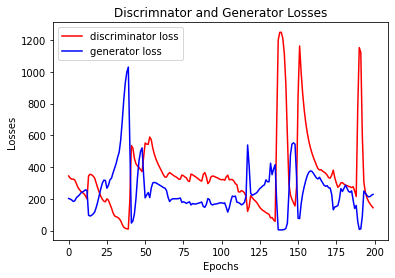

In [10]:
plt.plot(loss_dis, "r")
plt.plot(loss_gen, "b")
plt.legend(["discriminator loss", "generator loss"])
plt.title("Discrimnator and Generator Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.show()

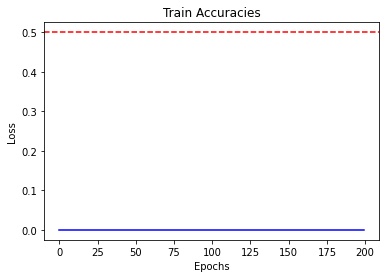

In [11]:
fig = plt.figure()
plt.plot(train_acc, color="b")
plt.axhline(0.5, linestyle='--', color="r")
plt.title("Train Accuracies")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [12]:
pred = torch.nn.Sigmoid()(dis(X_train))
print(torch.mean(pred))

tensor(0.9477, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [13]:
noise = torch.distributions.Uniform(0, 1).sample((1000, NOISE_DIM)).type(torch.float64)
pred = torch.nn.Sigmoid()(dis(gen(noise)))
print(torch.mean(pred))

tensor(0.5176, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [14]:
noise = torch.distributions.Uniform(0, 1).sample((1000, NOISE_DIM)).type(torch.float64)
out_G_test = gen(noise)
out_G_test = out_G_test.detach().numpy()
corr_gen = np.corrcoef(out_G_test, rowvar=False)
print(corr_gen.shape)

(13, 13)


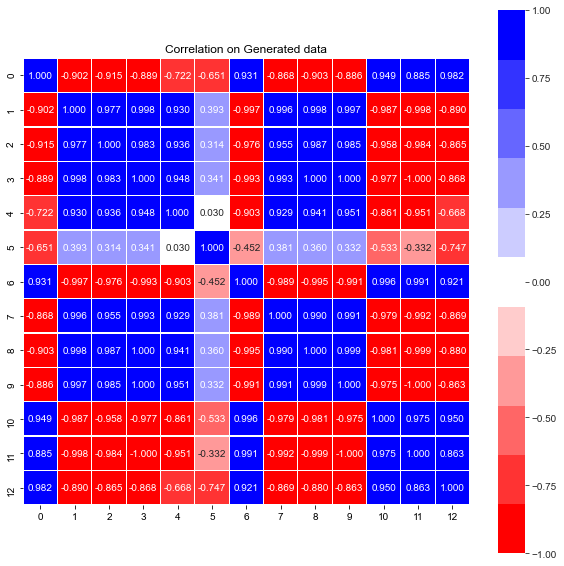

In [15]:
import matplotlib.colors as mcolors
import seaborn as sns

levs = range(12)
assert len(levs) % 2 == 0, 'N levels must be even.'

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(1, 0, 0), 
                                                          (1, 1., 1), 
                                                          (0, 0, 1)],
                                                 N=len(levs)-1,
                                                 )

fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_gen, cmap=cmap, annot=True, fmt=".3f", vmin=1, vmax=-1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Generated data")
    plt.show()

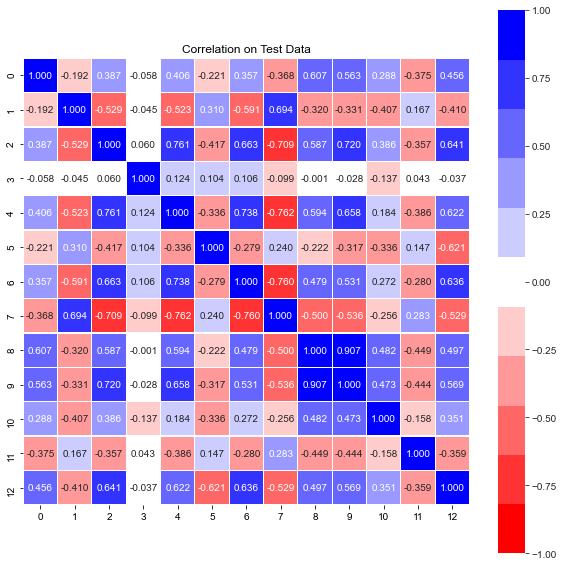

In [16]:
corr_test = np.corrcoef(X_train, rowvar=False)

fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_test, cmap=cmap, annot=True, fmt=".3f", vmin=1, vmax=-1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Test Data")
    plt.show()

In [17]:
for i in range(100):
    # Generate data
    noise = torch.distributions.Uniform(0, 1).sample((100000, NOISE_DIM)).type(torch.float64)
    out_G_test = gen(noise)

    # Combine generated data and held out data 
    data = torch.cat((out_G_test, X_test))
    labels = torch.cat((torch.zeros(out_G_test.shape[0]), torch.ones(X_test.shape[0])))

    # Randomly mix the test data and generated data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)

    data = data[indices]
    labels = labels[indices].unsqueeze(1)

    out_D_test = dis(data)
    out_D_test = torch.nn.Sigmoid()(out_D_test)
    result = (out_D_test > 0.5).type(torch.float)
    
    num_correct_one = labels[(result == labels) & (labels == 1)]
    print(torch.sum(num_correct_one))
    num_correct_zero = labels[(result == labels) & (labels == 0)]
    print(torch.sum(num_correct_zero))
    acc = (result == labels).type(torch.float)
    mean_acc = torch.mean(acc)

    print("Test accuracy {}: {}".format(i + 1, mean_acc))

tensor(152.)
tensor(0.)
Test accuracy 1: 0.05113228037953377
tensor(152.)
tensor(0.)
Test accuracy 2: 0.051262080669403076
tensor(152.)
tensor(0.)
Test accuracy 3: 0.050583112984895706
tensor(152.)
tensor(0.)
Test accuracy 4: 0.05071291700005531
tensor(152.)
tensor(0.)
Test accuracy 5: 0.05184120312333107
tensor(152.)
tensor(0.)
Test accuracy 6: 0.05071291700005531
tensor(152.)
tensor(0.)
Test accuracy 7: 0.05041337013244629
tensor(152.)
tensor(0.)
Test accuracy 8: 0.05073288455605507
tensor(152.)
tensor(0.)
Test accuracy 9: 0.05103243142366409
tensor(152.)
tensor(0.)
Test accuracy 10: 0.051022447645664215
tensor(152.)
tensor(0.)
Test accuracy 11: 0.05009385570883751
tensor(152.)
tensor(0.)
Test accuracy 12: 0.050593096762895584
tensor(152.)
tensor(0.)
Test accuracy 13: 0.05063303932547569
tensor(152.)
tensor(0.)
Test accuracy 14: 0.050263598561286926
tensor(152.)
tensor(0.)
Test accuracy 15: 0.05104241520166397
tensor(152.)
tensor(0.)
Test accuracy 16: 0.05104241520166397
tensor(152.)

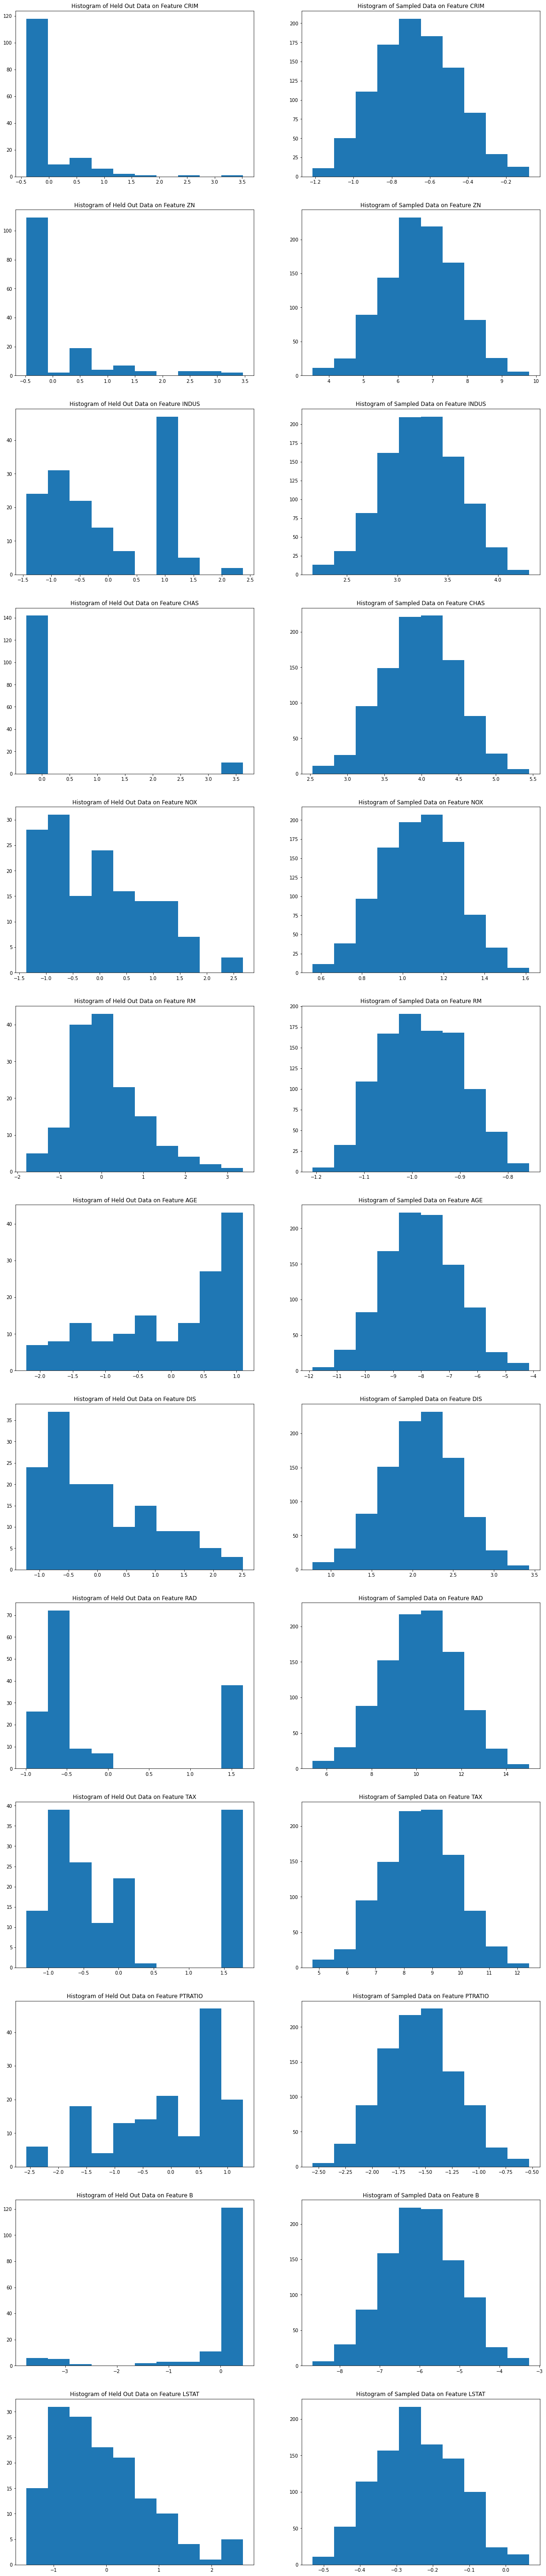

In [18]:
noise = torch.distributions.Uniform(0, 1).sample((1000, NOISE_DIM)).type(torch.float64)
outG = gen(noise)

x_out = outG.detach().numpy()
x_test = X_test.numpy()

figs, axs = plt.subplots(x_out.shape[1], 2, figsize=(20, 100))

for i in range(x_out.shape[1]):
    x_test_mean = x_test[:,i].mean()
    axs[i, 0].hist(x_test[:,i])
    axs[i, 0].set_title("Histogram of Held Out Data on Feature " + raw_data.feature_names[i])
    axs[i, 1].hist(x_out[:,i])
    axs[i, 1].set_title("Histogram of Sampled Data on Feature " + raw_data.feature_names[i])

plt.show()